In [ ]:
install.packages(c("ggplot2","dplyr","lubridate"))
library(ggplot2)
library(dplyr)
library(lubridate)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#load the dataset
taxi <- read.csv("taxi.csv")

In [ ]:
# Remove rows with missing values
taxi <- na.omit(taxi)
summary(taxi)

    DriveNo      Date.and.Time         Latitude       Longitude    
 Min.   :  2.0   Length:3817267     Min.   :39.36   Min.   :12.05  
 1st Qu.: 96.0   Class :character   1st Qu.:41.89   1st Qu.:12.47  
 Median :184.0   Mode  :character   Median :41.90   Median :12.48  
 Mean   :185.5                      Mean   :41.89   Mean   :12.48  
 3rd Qu.:273.0                      3rd Qu.:41.91   3rd Qu.:12.50  
 Max.   :369.0                      Max.   :42.25   Max.   :16.23  

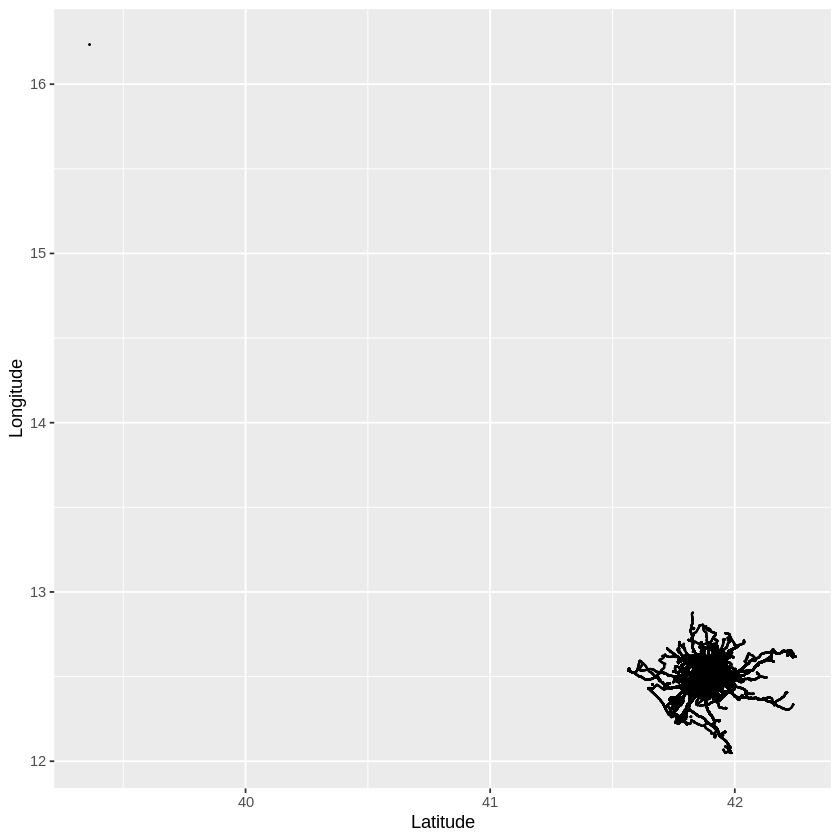

In [ ]:
#plot the whole dataset
ggplot(data = taxi, mapping = aes(x= Latitude, y = Longitude )) + geom_point(size = 0.01)

# The minimum, maximum, and mean location values.

By looking at the mean location values, we can know the common routes


From the plot and summary table above,it can be seen that there are some outliers in the data set. We can use the IQR method to remove outliers and noises to get a more insightful set of data

In [ ]:
# Select the Latitude and Longitude columns
q1_long <- quantile(taxi$Longitude, 0.25)
q3_long <- quantile(taxi$Longitude, 0.75)
iqr_long <- q3_long - q1_long

q1_lat <- quantile(taxi$Latitude, 0.25)
q3_lat <- quantile(taxi$Latitude, 0.75)
iqr_lat <- q3_lat - q1_lat

#set the boundary for Latitude and Longitude
lower_bound_long <- q1_long - 1.5 * iqr_long
upper_bound_long <- q3_long + 1.5 * iqr_long
lower_bound_lat <- q1_lat - 1.5 * iqr_lat
upper_bound_lat <- q3_lat + 1.5 * iqr_lat
outliers_long <- taxi$Longitude < lower_bound_long | taxi$Longitude > upper_bound_long
outliers_lat <- taxi$Latitude < lower_bound_lat | taxi$Latitude > upper_bound_lat

#df after preprocessing process
taxi_cleaned <- taxi[!outliers_long & !outliers_lat, ]
summary(taxi_cleaned)

    DriveNo      Date.and.Time         Latitude       Longitude    
 Min.   :  2.0   Length:2990438     Min.   :41.86   Min.   :12.43  
 1st Qu.: 94.0   Class :character   1st Qu.:41.90   1st Qu.:12.47  
 Median :179.0   Mode  :character   Median :41.90   Median :12.49  
 Mean   :182.2                      Mean   :41.90   Mean   :12.49  
 3rd Qu.:267.0                      3rd Qu.:41.91   3rd Qu.:12.50  
 Max.   :369.0                      Max.   :41.94   Max.   :12.54  

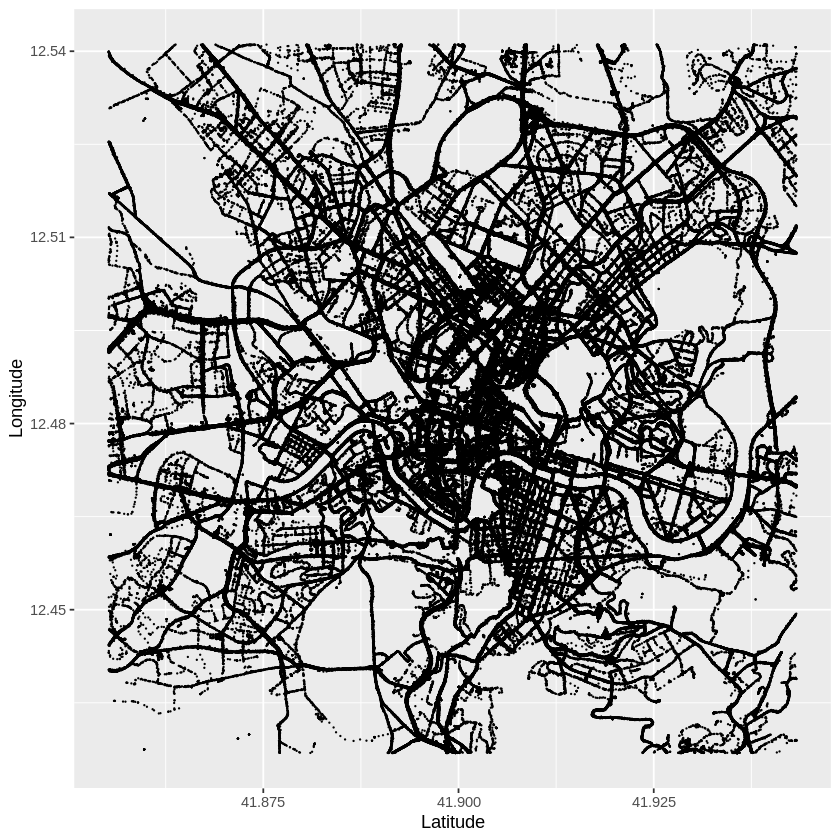

In [ ]:
#plot the new dataset
ggplot(data = taxi_cleaned, mapping = aes(x= Latitude, y = Longitude )) + geom_point(size = 0.01)

By using the IQR method, we can delete more than 4.8 million outlier. Also, a new plot is created. The new min, max, median location of the data is changed as well.

# Find the most active, least active taxi driver

To find the most active, the least active taxi drivers, we first need to compute the total active time for every taxi driver. From calculating the total time interval among time stamp for each driver, we can compute the total time recorded

In [ ]:
#Find the interval time
taxi_cleaned_sorted <- taxi_sorted %>%
  mutate(interval_driving_time = difftime(`Date.and.Time`, lag(`Date.and.Time`, default = first(`Date.and.Time`)), units = "secs")) %>%
  filter(interval_driving_time <= 1200 | is.na(interval_driving_time))
taxi_cleaned_sorted <- taxi_cleaned_sorted %>%mutate(total_interval_time = sum(interval_driving_time, na.rm = TRUE))

#show only one row for each driver
distinct_drive_no <- distinct(taxi_cleaned_sorted, DriveNo)
time_driven <- taxi_cleaned_sorted %>%
  filter(DriveNo %in% distinct_drive_no$DriveNo) %>%
  select(DriveNo, total_interval_time)

time_driven <- distinct(time_driven, DriveNo, .keep_all = TRUE)
head(time_driven,5)

DriveNo,total_interval_time
<int>,<drtn>
2,170639.7 secs
3,182192.7 secs
4,154517.3 secs
7,129638.6 secs
8,216444.2 secs


In [ ]:
#add the total time in hours column
time_driven <- time_driven %>%
  mutate(total_time_hours = total_interval_time / 3600)
time_driven$total_time_hours <- round(as.numeric(gsub("secs", "", time_driven$total_time_hours)), 2)

In [ ]:
#Find the most active drivers
sorted_time <- time_driven[order(time_driven$total_time_hours, decreasing = TRUE), ]
head(sorted_time,5)

DriveNo,total_interval_time,total_time_hours
<int>,<drtn>,<dbl>
94,219141.3 secs,60.87
8,216444.2 secs,60.12
24,199190.4 secs,55.33
21,197576.0 secs,54.88
255,197310.2 secs,54.81


In [ ]:
#Find the least active drivers
sorted_time <- time_driven[order(time_driven$total_time_hours, decreasing = FALSE), ]
head(sorted_time,5)

DriveNo,total_interval_time,total_time_hours
<int>,<drtn>,<dbl>
303,254.6704 secs,0.07
217,11811.6413 secs,3.28
328,25507.7989 secs,7.09
347,27273.4302 secs,7.58
75,27413.3973 secs,7.61


Using the *time_driven function*, we can find the total time each driver drove in that month. In this example, I'd like to examine the time of DriverNo = 109

In [ ]:
#Create new df for driverNo 109
myTaxi <- subset(taxi_cleaned_sorted, DriveNo == '109')
#find time driven by DriverNo109
drive_109 <- time_driven %>% filter(DriveNo == 109)
print(drive_109)

# A tibble: 1 × 3
# Groups:   DriveNo [1]
  DriveNo total_interval_time total_time_hours
    <int> <drtn>                         <dbl>
1     109 181326.6 secs                   50.4


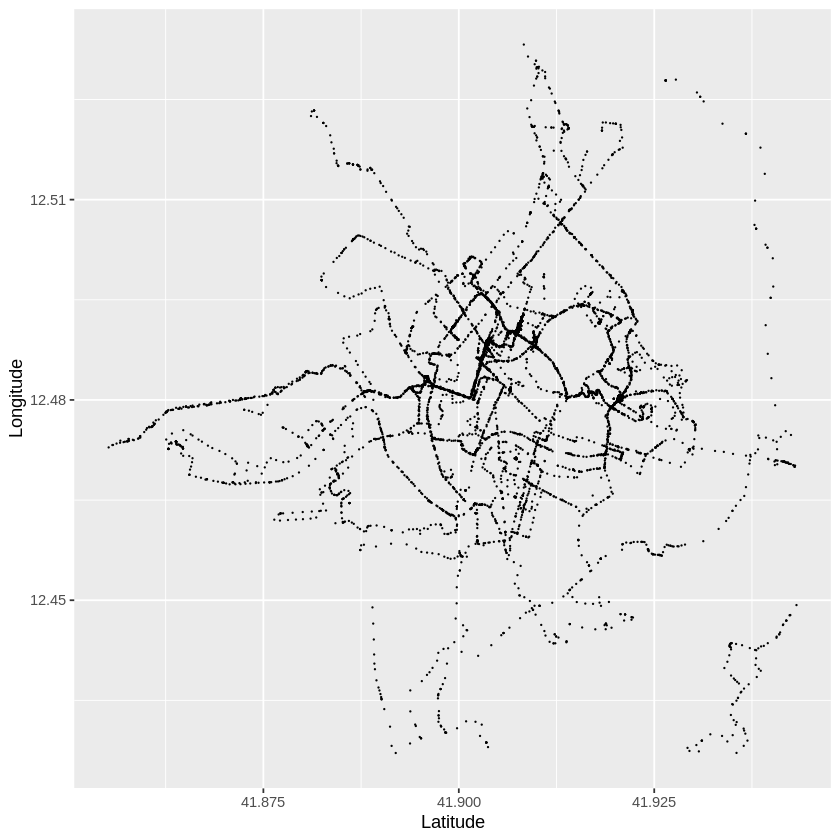

In [ ]:
#Plot the map driver 109 drove
ggplot(data = myTaxi,mapping = aes(x= Latitude, y = Longitude )) + geom_point(size = 0.01)

In [ ]:
# Haversine formula
haversine <- function(lat1, lon1, lat2, lon2) {
  R <- 6371  # Earth radius in kilometers
  dlat <- (lat2 - lat1) * pi / 180
  dlon <- (lon2 - lon1) * pi / 180
  a <- sin(dlat/2)^2 + cos(lat1 * pi / 180) * cos(lat2 * pi / 180) * sin(dlon/2)^2
  c <- 2 * atan2(sqrt(a), sqrt(1-a))
  distance <- R * c
  return(distance)
}

In [ ]:
#find the distance
myTaxi_length <- nrow(myTaxi)
distance = 0
for (i in 2:myTaxi_length) {
  lat1 <- myTaxi$Latitude[i-1]
  lon1 <- myTaxi$Longitude[i-1]
  lat2 <- myTaxi$Latitude[i]
  lon2 <- myTaxi$Longitude[i]
  distance[i] <- haversine(lat1, lon1, lat2, lon2)
  distance = distance + distance[i]
}

#add the distance column to myTaxi df
myTaxi$distance <- distance
sum(myTaxi$distance)


[1] 3465133